# Examine SST SO-EPT Coupling Across Reanalysis and Observational Products

# Utils

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
from typing import Tuple

## Plotting

In [2]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        contour_obj = ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            levels=[-600, -450, -300, -150, -100, -50, 0, 50, 100, 150, 300, 450, 600] # Contours for PSL
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .10, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    


## Coupling and Trend Utils

In [3]:
min_year, max_year = 1, 30
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)

def calculate_coupling_depending_on_time(
    so_ssts = None, 
    ept_ssts = None, 
    models = None,
):
    """
    Computes the coupling between Southern Ocean (SO) and Equatorial Pacific (EPT) sea surface temperatures (SSTs) 
    over different time scales using rolling window regressions.

    Parameters:
    -----------
    so_ssts : xarray.DataArray, optional
        Sea surface temperature anomalies for the Southern Ocean, with time as one of the dimensions.
    ept_ssts : xarray.DataArray, optional
        Sea surface temperature anomalies for the Equatorial Pacific, with time as one of the dimensions.
    models : list, optional
        List of model names corresponding to the SST data.

    Returns:
    --------
    xr.Dataset
        A dataset containing the following variables computed over multiple time scales:
        - 'reg': Linear regression coefficients between SO and EPT SSTs.
        - 'rvalues': Pearson correlation coefficients.
        - 'pvalues': Statistical significance of the correlations.
        - 'variance_so': Variance of SO SSTs.
        - 'variance_ept': Variance of EPT SSTs.
    """
    time = [*months, *years]
    reg_coeffs, rvalues, pvalues, variance_so, variance_ept = [], [], [], [], []
    for year in time:
        ts_so_ssts = get_rolling_timeseries(so_ssts, window=year, step=12, gradient=False)
        ts_ept_ssts = get_rolling_timeseries(ept_ssts, window=year, step=12, gradient=False)

        variance_ept.append(ts_ept_ssts.std(dim="time"))
        variance_so.append(ts_so_ssts.std(dim="time"))
        rvalues.append(xscore.pearson_r(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['years', 'model'], np.array(reg_coeffs))}, coords={'model': models, 'years': time})
    rvalues = xr.Dataset({'rvalues': (['years', 'model'], np.array(rvalues))}, coords={'model': models, 'years': time})
    pvalues = xr.Dataset({'pvalues': (['years', 'model'], np.array(pvalues))}, coords={'model': models, 'years': time})
    variance_so = xr.Dataset({'variance_so': (['years', 'model'], np.array(variance_so))}, coords={'model': models, 'years': time})
    variance_ept = xr.Dataset({'variance_ept': (['years', 'model'], np.array(variance_ept))}, coords={'model': models, 'years': time})

    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues, variance_so, variance_ept])
    return regs_dataset


def remove_land_full(ds, var="skt"):
    """
    Remove land from dataset using global_land_mask
    """
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data, include_T=True):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    if include_T: data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_space(data):
    data = data.bounds.add_bounds("T")
    return data

def get_triangle_mean(tos, latmin, latmax, lonmin, lonmax, RES):
    """
    Defines the EPT sector
    """
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ntime, nlat, nlon = tos.shape
    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[2]: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:nlats, i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
     
    return ctos

def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da

def get_region_reg(cmip_region_ssts, cmip_regressor, window: float = 12*5):
    ts_region_ssts = get_rolling_timeseries(cmip_region_ssts, window=window, step=12, gradient=False)
    ts_cmip_reg = get_rolling_timeseries(cmip_regressor, window=window, step=12, gradient=False)

    reg_sst = xscore.linslope(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)

    pvalues_sst = xscore.pearson_r_eff_p_value(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)
    # pvalues_models = (pvalues_sst < .05).sum(dim="model") < ts_region_ssts.model.size/2 # This evaluates to 1 if more than half modes are sig

    return reg_sst, pvalues_sst

def preprocess(ds, varname):
    ds = remove_land_full(ds, var=varname).rename(varname).to_dataset()
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures(varname, "month", reference_period=("1990-01-01", "2010-12-31"))

    # Regrid to 2.5x2.5 degree grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    ds = ds.regridder.horizontal(varname, output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    return ds

def detrend(da):
    time_idx = xr.DataArray(np.arange(len(da.time)), dims="time")
    slope = xscore.linslope(time_idx, da, dim="time", skipna=False)
    da = da - slope*time_idx
    return da 


# Load Obs

In [ ]:
era = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_winds_msl.nc").rename({"valid_time": "time"})
era5_u = era[["u10"]]
era5_v = era[["v10"]]

era5_msl = era[["msl"]]
era5_msl = preprocess(era5_msl, "msl")
era5_msl = detrend(era5_msl["msl"]).rename("msl").to_dataset()
era5_msl = era5_msl.rename({"longitude": "lon", "latitude": "lat"})

era = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_tp_radiation.nc").rename({"valid_time": "time"})
era5_total_precip = fix_coords(era5[["tp"]])
era5_total_precip = preprocess(era5_total_precip, "tp")
era5_total_precip = detrend(era5_total_precip["tp"]).rename("tp").to_dataset()

# Calculate Walker Circulation
era5_msl = fix_coords(era5_msl)
west = era5_msl.sel(lat=slice(-5, 5), lon=slice(130, 150)).spatial.average("msl")["msl"]
east = era5_msl.sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("msl")["msl"]
walker = fix_coords_no_space((east - west).to_dataset(name="walker"))
walker_anomaly = walker.temporal.departures("walker", "month")
walker_anomaly

In [ ]:
# era5_u = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_u_component_of_wind.nc")
# era5_v = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_v_component_of_wind.nc")

# era5_total_precip = fix_coords(xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_total_precipitation.nc"))
# era5_total_precip = preprocess(era5_total_precip, "tp")
# era5_total_precip = detrend(era5_total_precip["tp"]).rename("tp").to_dataset()

# era5_msl = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_mean_sea_level_pressure.nc")



# era5_msl = preprocess(era5_msl.isel(expver=0).drop("expver"), "msl")
# era5_msl = detrend(era5_msl["msl"].fillna(0)).rename("msl").to_dataset()
# era5_msl = era5_msl.rename({"longitude": "lon", "latitude": "lat"})

# # Calculate Walker Circulation
# era5_msl = fix_coords(era5_msl)
# west = era5_msl.sel(lat=slice(-5, 5), lon=slice(130, 150)).spatial.average("msl")["msl"]
# east = era5_msl.sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("msl")["msl"]
# walker = fix_coords_no_space((east - west).to_dataset(name="walker"))
# walker_anomaly = walker.temporal.departures("walker", "month")
# walker_anomaly

<xarray.Dataset>
Dimensions:    (time: 538, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
Dimensions without coordinates: bnds
Data variables:
    walker     (time) float64 -39.42 29.42 10.13 31.75 ... -132.4 -40.0 -40.45
    time_bnds  (time, bnds) datetime64[ns] 1978-12-16T12:00:00 ... 2023-10-16

In [27]:
def load_sst(product_name="ERA5", start_time="1870-01-01", end_time="2019-12-31"):
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)

    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
    
    elif product_name == 'vc_E3SM-2-0hist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='E3SM-2-0hist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
    
    elif product_name == 'vc_NorESM2-LMhist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='NorESM2-LMhist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_EC-Earth3hist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='EC-Earth3hist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_CESM2hist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='CESM2hist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_UKESM1.0-LLhist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='UKESM1.0-LLhist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_GFDL-ESM4hist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='GFDL-ESM4hist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_SAM0-UNICONhist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='SAM0-UNICONhist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == 'vc_HadGEM3-GC31-LLhist':
        vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
        ds = vc.sel(prior='HadGEM3-GC31-LLhist', time=slice(start_time, end_time)).rename({"lon": "longitude", "lat": "latitude", "tos": "sst"})
        ds = ds.drop(["mask", "nino34", "so", "zonal_sst", "prior", "wts"])
        
    elif product_name == "NOAA-ERSSTv5":
        # ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input/NOAA-PSL/ERSST5/v20231110/ERSST.5.sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        # ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, end_time)) #"2017-12-31"))
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input/NOAA-PSL/COBE1/v20230526/COBE.1.sst.mon.mean.nc").sel(time=slice(start_time, end_time)) #"2017-12-31"))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        # ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input/NOAA-PSL/COBE2/v20230526/COBE.2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice("1982-01-01", end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input//MOHC/HadISST1-1/v20231114/HadISST.1.1.sst.nc").sel(time=slice(start_time, end_time)) #"2017-12-31"))
        ds["sst"] = xr.where(ds["sst"] == -1000, np.nan, ds["sst"]) # Some polar points are -1000

    elif product_name == "HadISST-2.2":
        # ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "HadISST-2.3":
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input/MOHC/HadISST2-3/v20230526/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time)) #"2019-12-31"))

    elif product_name == "HadISST-2.4":
        ds = xc.open_dataset("/p/user_pub/PCMDIobs/obs4MIPs_input/MOHC/HadISST2-4/v20241002/HadISST.2.4.0.0_ensemble_member_001_sst.nc").sel(time=slice(start_time, end_time)) #"2019-12-31"))

    elif product_name == "HadSST4":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    else: 
        return
        
    
    ###### PREPROCESSING ######
    ds = remove_land_full(ds, var="sst").rename("sst").to_dataset()
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures("sst", "month")
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal("sst", output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    # Detrend
    ds["sst"] = detrend(ds["sst"])

    # # ds["time"] = ssts.indexes["time"].to_datetimeindex().values.astype('datetime64[M]')
    # time_idx = xr.DataArray(np.arange(len(ds.time)), dims="time")
    # ssts_slope = xscore.linslope(time_idx, ds["sst"], dim="time", skipna=False)
    # ds["sst"] = ds["sst"] - ssts_slope*time_idx
    

    # Get SST Anomalies in Triangular Region
    latmin, latmax = -38.75, -1.25
    lonmin, lonmax = -178.75, -71.25
    RES = 2.5
    ept = get_triangle_mean(ds["sst"].copy(), latmin, latmax, lonmin, lonmax, RES)
    ept_mean  = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

    # Get SST Anomlies in Southern Ocean
    so_mean = ds["sst"].sel(longitude=slice(-180, -75), latitude=slice(-70, -50))
    so_mean = (fix_coords(so_mean.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

    # Calculate WE Gradient
    west = fix_coords(ds["sst"].rename("tos").to_dataset()).sel(latitude=slice(-5, 5), longitude=slice(110, 150)).spatial.average("tos")["tos"]
    east = fix_coords(ds["sst"].rename("tos").to_dataset()).sel(latitude=slice(-5, 5), longitude=slice(-180, -80)).spatial.average("tos")["tos"]
    WE_sst = fix_coords_no_space((west - east).to_dataset(name="WE_sst"))
    WE_sst_anomaly = WE_sst.temporal.departures("WE_sst", "month")["WE_sst"]

    return ds, so_mean, ept_mean, WE_sst_anomaly

In [28]:
def process_obs_data(save_path: str):
    obs_sst_so_ept_reg = []
    obs_sst_reg, obs_psl_reg, obs_pr_reg = [], [], []
    obs_sst_timeseries = []
    obs_walker_so_reg, obs_we_so_reg = [], []

    for i, sst_product in enumerate(SST_PRODUCTS): 
        print(f"Processing {sst_product}")
        ssts, so_mean, ept_mean, WE_sst_anomaly = load_sst(sst_product)
        # Merge Datasets
        obs_sst = xr.merge([
            ssts,
            so_mean.rename("Raw_SO_Mean").to_dataset(),
            ept_mean.rename("Raw_EPT_Mean").to_dataset(),
            WE_sst_anomaly.rename("WE_sst_anomaly").to_dataset(),
        ])
        obs_sst = obs_sst.expand_dims("model")
        obs_sst["model"] = [sst_product]
        obs_sst_timeseries.append(obs_sst)
        window = 12*5

        # Calculate dMSL/dSO_sst Regression Coeff Maps
        if not np.issubdtype(obs_sst.time.dtype, np.datetime64):
            obs_sst["time"] = obs_sst.indexes["time"].to_datetimeindex().values.astype('datetime64[M]')
        else: 
            obs_sst["time"] = obs_sst.time.values.astype('datetime64[M]')

        msl = era5_msl.expand_dims("model")
        msl["model"] = [sst_product]
        shared_time = np.intersect1d(msl.time.values, obs_sst.time.values)
        reg_so_psl, p_so_psl = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            msl["msl"].sel(time=shared_time),
            window=window
        )
        obs_psl_reg.append(xr.merge([reg_so_psl.rename("reg_psl"), p_so_psl.rename("p_psl")]))

        # Calculate dPr/dSO_sst Regression Coeff Maps
        pr = era5_total_precip.expand_dims("model")
        pr["model"] = [sst_product]
        shared_time = np.intersect1d(pr.time.values, obs_sst.time.values)
        reg_so_pr, p_so_pr = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            pr["tp"].sel(time=shared_time),
            window=window
        )
        obs_pr_reg.append(xr.merge([reg_so_pr.rename("reg_pr"), p_so_pr.rename("p_pr")]))

        # Calculate dSST/dSO_sst Regression Coeff Maps
        reg_so_sst, p_so_sst = get_region_reg(
            obs_sst["Raw_SO_Mean"],
            obs_sst["sst"],
            window=window
        )
        obs_sst_reg.append(xr.merge([reg_so_sst.rename("reg_sst"), p_so_sst.rename("p_sst")]))

        obs_sst_so_ept_reg.append(
            calculate_coupling_depending_on_time(obs_sst["Raw_SO_Mean"], obs_sst["Raw_EPT_Mean"], models=obs_sst.model)
        )
        # Calculate dWalker/dSO_sst
        walker_anomaly_t = walker_anomaly.copy()
        walker_anomaly_t["walker"] = walker_anomaly_t["walker"].expand_dims("model")
        walker_anomaly_t["model"] = [sst_product]
        reg_so_walker, p_so_walker = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            walker_anomaly_t["walker"].sel(time=shared_time),
            window=window
        )
        obs_walker_so_reg.append(
            xr.merge([reg_so_walker.rename("reg_walker"), p_so_walker.rename("p_walker")])
        )
        # Calculate dWE/dSO_sst
        reg_so_we, p_so_we = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            obs_sst["WE_sst_anomaly"].sel(time=shared_time),
            window=window
        )
        obs_we_so_reg.append(
            xr.merge([reg_so_we.rename("reg_we"), p_so_we.rename("p_we")])
        )
        print(f"Finished processing {sst_product}")

    obs_psl_reg = xr.concat(obs_psl_reg, dim="model")
    obs_pr_reg = xr.concat(obs_pr_reg, dim="model")
    obs_sst_reg = xr.concat(obs_sst_reg, dim="model")
    obs_walker_so_reg = xr.concat(obs_walker_so_reg, dim="model")
    obs_we_so_reg = xr.concat(obs_we_so_reg, dim="model")
    obs_regs = xr.merge([obs_psl_reg, obs_pr_reg, obs_sst_reg, obs_walker_so_reg, obs_we_so_reg])
    # obs_regs.to_netcdf(os.path.join(save_path, "obs_so_regression_coeffs.nc"))

    obs_sst_so_ept_reg = xr.concat(obs_sst_so_ept_reg, dim="model")
    # obs_sst_so_ept_reg.to_netcdf(os.path.join(save_path, "obs_so_ept_coupling.nc"))

    obs_sst_timeseries = xr.concat(obs_sst_timeseries, dim="model")
    # obs_sst_timeseries.to_netcdf(os.path.join(save_path, "obs_sst_timeseries.nc"))

    return obs_regs, obs_sst_so_ept_reg, obs_sst_timeseries

# SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE2", "HadISST-2.2"]
# SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadSST4", "HadISST-2.3", "HadISST-2.2"]
# SST_PRODUCTS = ["PCMDI-AMIP-1-1-9", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadISST-2.3", 'vc_E3SM-2-0hist', 'vc_NorESM2-LMhist', 'vc_EC-Earth3hist', 'vc_CESM2hist', 'vc_UKESM1.0-LLhist', 'vc_GFDL-ESM4hist', 'vc_SAM0-UNICONhist', 'vc_HadGEM3-GC31-LLhist']
# SST_PRODUCTS = ['vc_E3SM-2-0hist', 'vc_NorESM2-LMhist', 'vc_EC-Earth3hist', 'vc_CESM2hist', 'vc_UKESM1.0-LLhist', 'vc_GFDL-ESM4hist', 'vc_SAM0-UNICONhist', 'vc_HadGEM3-GC31-LLhist', "PCMDI-AMIP-1-1-9", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadISST-2.3"]
SST_PRODUCTS = ["PCMDI-AMIP-1-1-9", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadISST-2.3", "HadISST-2.4", 'vc_E3SM-2-0hist', 'vc_NorESM2-LMhist', 'vc_EC-Earth3hist', 'vc_CESM2hist', 'vc_UKESM1.0-LLhist', 'vc_GFDL-ESM4hist', 'vc_SAM0-UNICONhist', 'vc_HadGEM3-GC31-LLhist']
# SST_PRODUCTS = ["HadSST4", "COBE", "COBE2"]

obs_regs, obs_sst_so_ept_reg, obs_sst_timeseries = process_obs_data("/home/espinosa10/SO-EP-teleconnection/Data")

Processing PCMDI-AMIP-1-1-9
For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing PCMDI-AMIP-1-1-9
Processing NOAA-ERSSTv5
For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

Finished processing NOAA-ERSSTv5
Processing COBE
For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

Finished processing COBE
Processing COBE2


2025-02-28 11:19:46,554 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing COBE2
Processing HadISST-1.1


2025-02-28 11:20:37,205 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing HadISST-1.1
Processing HadISST-2.3
For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

Finished processing HadISST-2.3
Processing HadISST-2.4
For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing HadISST-2.4
Processing vc_E3SM-2-0hist


2025-02-28 11:22:54,429 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_E3SM-2-0hist
Processing vc_NorESM2-LMhist


2025-02-28 11:23:31,239 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_NorESM2-LMhist
Processing vc_EC-Earth3hist


2025-02-28 11:24:08,203 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_EC-Earth3hist
Processing vc_CESM2hist


2025-02-28 11:24:45,295 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_CESM2hist
Processing vc_UKESM1.0-LLhist


2025-02-28 11:25:22,527 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_UKESM1.0-LLhist
Processing vc_GFDL-ESM4hist


2025-02-28 11:25:59,801 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_GFDL-ESM4hist
Processing vc_SAM0-UNICONhist


2025-02-28 11:26:36,357 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_SAM0-UNICONhist
Processing vc_HadGEM3-GC31-LLhist


2025-02-28 11:27:13,672 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing vc_HadGEM3-GC31-LLhist


In [39]:
save_path = "/home/espinosa10/SO-EP-teleconnection/Data"
obs_regs.to_netcdf(os.path.join(save_path, "obs_so_regression_coeffs.nc"))
obs_sst_so_ept_reg.to_netcdf(os.path.join(save_path, "obs_so_ept_coupling.nc"))
obs_sst_timeseries.to_netcdf(os.path.join(save_path, "obs_sst_timeseries.nc"))
obs_sst_so_ept_reg.sel(years=12*5).reg

PermissionError: [Errno 13] Permission denied: b'/home/espinosa10/SO-EP-teleconnection/Data/obs_so_ept_coupling.nc'

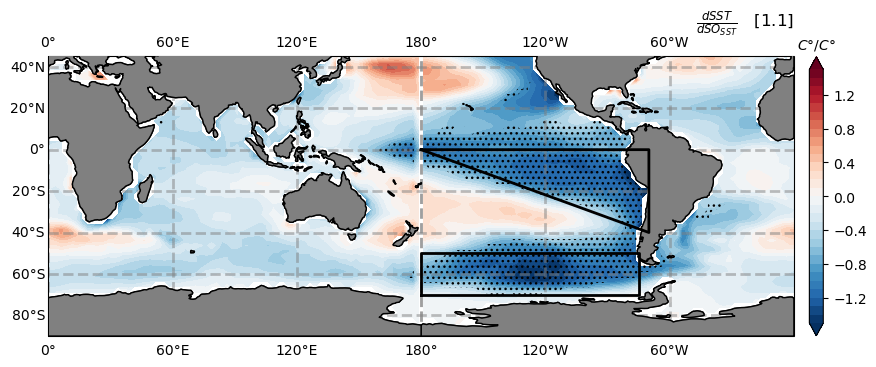

In [30]:
# Calculate the average of all maps
avg_reg = obs_sst_so_ept_reg.sel(years=12*5).reg.mean().values
axis_fontsize = 12
title_fontsize = 16

# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot the average map
img = _global_plot(
    ax,
    data=-obs_regs["reg_sst"].mean("model"),
    lat=obs_regs["reg_sst"].latitude,
    lon=obs_regs["reg_sst"].longitude,
    levels=np.arange(-1.5, 1.6, .1),
    cmap="RdBu_r",
    cbar_label=r"$Wm^{-2}/C\degree$",
    pvalues=((obs_regs["p_sst"] < .10).sum(dim="model") < obs_regs.model.size/2),
    # contours=-obs_regs["reg_psl"].mean("model").values,
)

cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)
# ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   ", loc="right", fontsize=title_fontsize*.75)

ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   " + f"[{np.around(avg_reg, 3)}]", loc="right", fontsize=title_fontsize*.75)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_response_so_RdBu_obs-mean_vc.png")

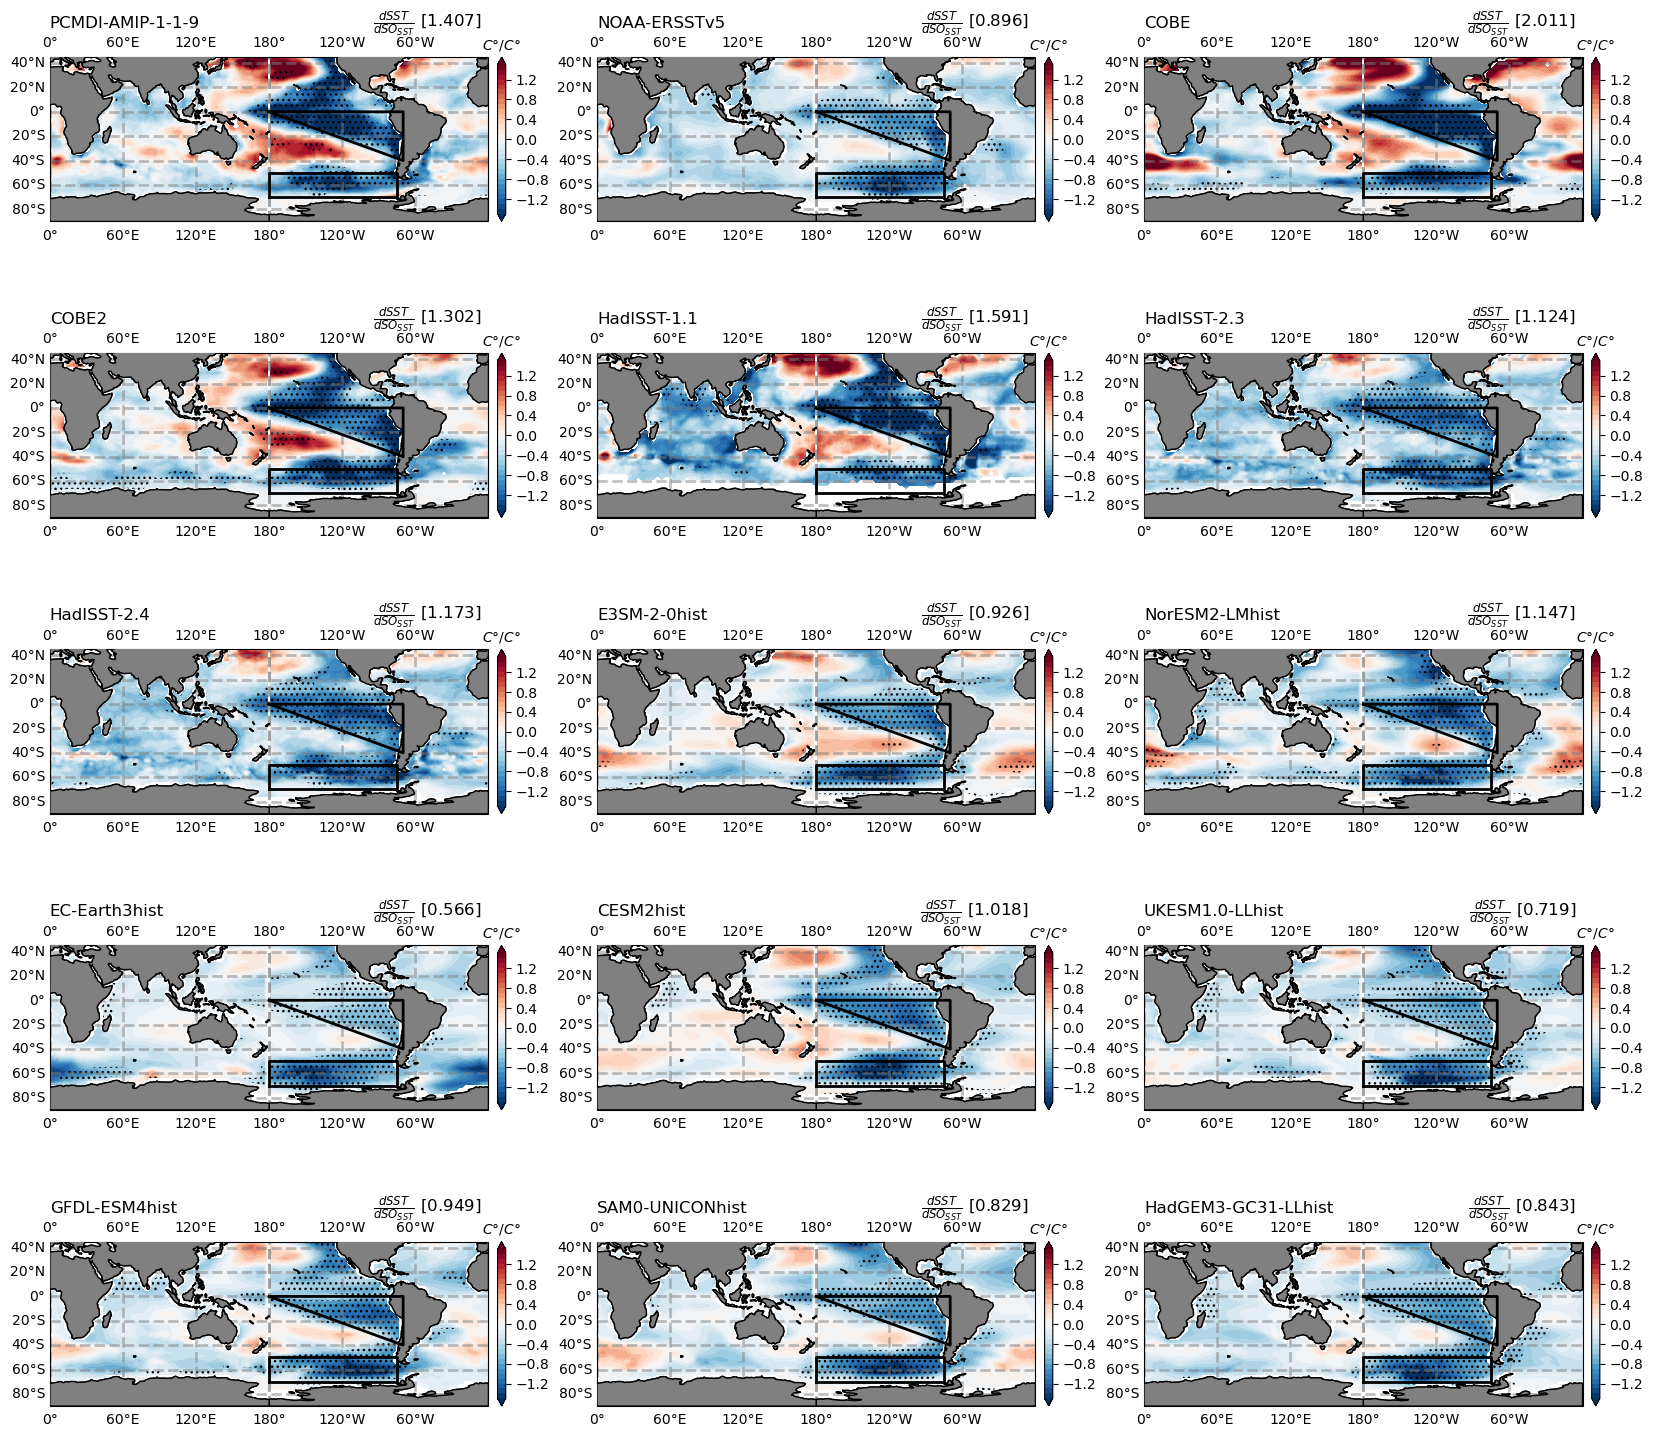

In [40]:
fig, axes = plt.subplots(5, 3, figsize=(20, 25), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.subplots_adjust(hspace=-.60)
axis_fontsize = 12
title_fontsize = 16

for i, (ax, cmodel) in enumerate(zip(axes.flat, obs_regs["reg_sst"].model)):
    # Plot spatia6 map
    ax = axes.flat[i]
    img = _global_plot(
        ax,
        data=-obs_regs["reg_sst"].sel(model=cmodel),
        lat=obs_regs["reg_sst"].latitude,
        lon=obs_regs["reg_sst"].longitude,
        levels=np.arange(-1.5, 1.6, .1),
        cmap="RdBu_r",
        pvalues=obs_regs["p_sst"].sel(model=cmodel),
        cbar_label=r"$Wm^{-2}/C\degree$",
        # contours=-obs_regs["reg_psl"].sel(model=cmodel).values,
    )
    ax.set_title(r"$\frac{dSST}{dSO_{SST}}$" + f" [{np.around(obs_sst_so_ept_reg.sel(model=cmodel).sel(years=12*5).reg.values, 3)}]  ", loc="right", fontsize=title_fontsize*.75)

    cmodel = str(cmodel.values)[3:] if str(cmodel.values)[:3] == "vc_" else cmodel.values
    ax.set_title(cmodel, loc="left", fontsize=title_fontsize*.75)
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)

# fig.delaxes(axes.flat[-1])
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_so_reg_coeffs_w-vc.png")

# Lagged Analysis

In [ ]:
def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset

lags = np.arange(-12*5, 12*5)
window = 12
lagged_so_ept_coupling = []
for cmodel in obs_sst_all.model:
    so_cmodel = obs_sst_all.sel(model=[cmodel.values])["Raw_SO_Mean"]
    ept_cmodel = obs_sst_all.sel(model=[cmodel.values])["Raw_EPT_Mean"]
    so_rolling = get_rolling_timeseries(so_cmodel, window=window, step=1, gradient=False)
    ept_rolling = get_rolling_timeseries(ept_cmodel, window=window, step=1, gradient=False)
    lagged_so_ept_coupling.append(lagged_regression(so_rolling, ept_rolling, lags))

lagged_so_ept_coupling = xr.concat(lagged_so_ept_coupling, dim="model")
# lagged_so_ept_coupling.to_netcdf("/home/espinosa10/SO-EP-teleconnection/Data/lagged_so_ept_coupling_obs.nc")

<xarray.Dataset>
Dimensions:  (lags: 120, model: 6)
Coordinates:
  * model    (model) <U16 'NOAA-OISST-v2.1' 'PCMDI-AMIP-1-1-9' ... 'HadISST-2.2'
  * lags     (lags) int64 -60 -59 -58 -57 -56 -55 -54 ... 53 54 55 56 57 58 59
Data variables:
    rvalues  (lags, model) float64 0.08662 -0.01206 0.2198 ... -0.05078 0.0345
    reg      (lags, model) float64 0.1789 -0.03685 0.3211 ... -0.1496 0.06895
    pvalues  (lags, model) float64 0.9134 0.966 0.7802 ... 0.9063 0.8519 0.9483